In [1]:
import torch
from torch import nn 
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset

import sys
sys.path.append('../')
from model import ShallowMLP
from dataset import SyntheticVisualFlowDataset
from experiment.utils import set_seed, init_model, Logger, Trainer, Checkpointer
from plotting.utils import config

from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

import numpy as np
from argparse import Namespace

import matplotlib.pyplot as plt

## helper functions

In [2]:
def custom_collate_fn(batch):
    visual_flow_t = torch.tensor(np.array([item[0] for item in batch]), dtype=torch.float32)
    visual_flow_tp1 = torch.tensor(np.array([item[1] for item in batch]), dtype=torch.float32)
    speeds_t = torch.tensor(np.array([item[2] for item in batch]), dtype=torch.float32)
    speeds_tp1 = torch.tensor(np.array([item[3] for item in batch]), dtype=torch.float32)
    
    return visual_flow_t, visual_flow_tp1, speeds_tp1, speeds_t, speeds_tp1

In [3]:
def get_mm(net, dataloader_mm, recon_loss_coeff=0, l5_scale=0, l23_scale=0, l5_indices=None, l23_indices=None):
    optimizer = optim.SGD(net.parameters(), lr=1e-3) # dummy optimizer
    net.to('cpu')
    mm = {'baseline': {}, 'mm': {}}
    for k in mm.keys():
        mm[k] = {'L2/3_fc1': [],'L2/3_fc2': [],'L5_fc1': [], 'L5_fc2': [], "speed": [], "l5_scale_indices": []}
        for i, (x1,x2,s1, s2) in enumerate(dataloader_mm):
            x1 = x1.float()
            x2 = x2.float()
            s1 = s1.float()
            s2 = s2.float()
            # flatten x1 and x2
            net.reset_hook()
            net.register_hook(register=True) 

            x1_ = x1.view(x1.shape[0], -1).clone()
            x2_ = x2.view(x2.shape[0], -1).clone()
            if k == 'mm':
                x1_ = torch.rand_like(x1_)* 1e-3
                x2_ = x1_.clone()
            s2_ = s2.clone()
            mm[k]['speed'].append(s2_.numpy())

            l4_out, l23_out, l5_pred, l5_out, recon = net(x1_, x2_, s2_)
            
            if (i > len(dataloader_mm)/4) and (i < len(dataloader_mm)/2 + 100):
                if k == 'mm' and l5_scale != 0:
                    mm[k]['l5_scale_indices'].append(i)
                    # create a mask where only l5_indices are set to 1 and the rest to 0
                    if l5_indices is None:
                        mask = torch.ones_like(l5_out)
                    else:
                        mask = torch.zeros_like(l5_out)
                        mask[:, l5_indices] = 1
                    l5_out = l5_out + (torch.ones_like(l5_out)*torch.max(torch.abs(l5_out))*l5_scale) * mask
                if k == 'mm' and l23_scale != 0:
                    net.l23.l23_scale = l23_scale
            else:
                net.l23.l23_scale = 0
                
            loss = recon_loss_coeff*F.mse_loss(recon, x2_) + F.mse_loss(l5_pred, l5_out)
            optimizer.zero_grad()
            loss.backward()

            mm[k]['L2/3_fc1'].append(net.l23.hook['fc1'][0][0].numpy())
            mm[k]['L5_fc1'].append(net.l5.hook['fc1'][0][0].numpy())

    return mm

# multi-layer network

In [4]:
var_scaler=2.0 ; num_speeds=11 ; input_dim=8 ; max_value=10
dataset = SyntheticVisualFlowDataset(num_samples=2000, dimensions=input_dim, max_value=max_value,  var_scaler=var_scaler, speed_func="random_walk", num_speeds=num_speeds)


dataloader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])


In [5]:
visual_flow_t, visual_flow_tp1, td, speeds_t, speeds_tp1 = next(iter(dataloader))
print(f'{visual_flow_t.shape=} / {visual_flow_tp1.shape=} / {speeds_t.shape=} / {speeds_tp1.shape=}')

visual_flow_t.shape=torch.Size([32, 8]) / visual_flow_tp1.shape=torch.Size([32, 8]) / speeds_t.shape=torch.Size([32, 1]) / speeds_tp1.shape=torch.Size([32, 1])


In [6]:

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [9]:
args = Namespace()
args.input_dim = input_dim
args.hidden_dim = 32
args.latent_dim = 16
args.td = 1 # 1
args.lr = 1e-3
args.epoch = 1101
args.batch_size = 32
args.ablate_l23_l5=False
args.ablate_topdown=False
args.ablate_delay=False
args.activation='relu'
args.l23_modulation_factor=0.3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

logger = Logger('mismach experiment')
net = init_model(ShallowMLP,  **vars(args), logger=logger)
net = net.to(device)
optimizer = optim.Adam(net.parameters(), lr=args.lr)

trainer = Trainer(net, dataloader, optimizer, args, logger, device)

Experiment: mismach experiment


In [10]:
trainer.train()

epoch: 0, ssl_loss: 13.075563110056377, recon_loss: 119.58553180618891
epoch: 100, ssl_loss: 0.12232106510135862, recon_loss: 0.08526118064210528
epoch: 200, ssl_loss: 0.05951621554910191, recon_loss: 0.0316252096127423
epoch: 300, ssl_loss: 0.028602695743006373, recon_loss: 0.009541402748298077
epoch: 400, ssl_loss: 0.01957726132656847, recon_loss: 0.006916154286868516
epoch: 500, ssl_loss: 0.014852382597469148, recon_loss: 0.006484364898550132
epoch: 600, ssl_loss: 0.013619214458952821, recon_loss: 0.007344534103241231
epoch: 700, ssl_loss: 0.011028881731723983, recon_loss: 0.005779853423259088
epoch: 800, ssl_loss: 0.010069522895805892, recon_loss: 0.006050119764127192
epoch: 900, ssl_loss: 0.009393900847210297, recon_loss: 0.006231970002224285
epoch: 1000, ssl_loss: 0.00878710500038569, recon_loss: 0.007603305783714094
epoch: 1100, ssl_loss: 0.008357832577848246, recon_loss: 0.006512459071855697


In [11]:

class MidpointNormalize(colors.Normalize):
    """Normalise the colorbar."""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
    
def plot_heatmap(data, ax,  name, color_bar=False, save_fig=False):
    # sorted_data = data
    sorted_data = data[np.mean(data, axis=1).argsort()][::-1]
    # sorted_data = data
    min_, max_ = -np.max(np.abs(sorted_data)), np.max(np.abs(sorted_data))
    mymin, mymax =min_, max_
    print(mymin, mymax)
    cmap = LinearSegmentedColormap.from_list("", ["#23327b","white", "#af0e51"])


    im = ax.imshow(sorted_data, norm=MidpointNormalize(mymin, mymax, 0.),
                    aspect='auto',interpolation='nearest', cmap=cmap)
    
    ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=True,
            labelsize=config.axis_fontsize # labels along the bottom edge are off
            ) # labels along the bottom edge are off
    ax.set_xlabel('Time [s]', fontsize=config.axis_fontsize)
    ax.set_ylabel('sorted neuron #', fontsize=config.axis_fontsize)
    divider = make_axes_locatable(ax)
    if color_bar:
        cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
        cbformat.set_powerlimits((-2,2))  
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar_ax = plt.colorbar(im, cax=cax, orientation='vertical',format=cbformat)
        cbar_ax.ax.tick_params(labelsize=config.tick_fontsize)
        cbar_ax.set_label('prediction error', fontsize=config.axis_fontsize)
    # ax.set_ylabel('Sorted neurons #')
    ax.set_yticks(np.arange(0,data.shape[0],4), minor=False)
    # yticks font size
    ax.yaxis.set_tick_params(labelsize=config.tick_fontsize) 
    if save_fig:
        plt.savefig(f'saved_figs/{name}', dpi=300, bbox_inches='tight')
    else:
        print('not saving fig')


In [12]:
dataset_mm = SyntheticVisualFlowDataset(num_samples=2000, dimensions=input_dim, max_value=max_value, var_scaler=var_scaler, speed_func="random_walk", num_speeds=num_speeds)
dataloader_mm = DataLoader(dataset_mm, batch_size=1, shuffle=False)
mm_toy = get_mm(net, dataloader_mm, recon_loss_coeff=0.0)

speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])


-2.354676 2.354676
not saving fig
-0.9871576 0.9871576
not saving fig


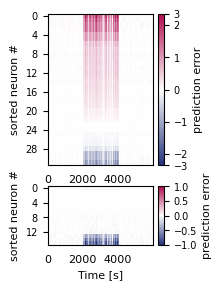

In [13]:
mm_l23 = (np.array(mm_toy['mm']["L2/3_fc1"]) - np.array(mm_toy['baseline']["L2/3_fc1"])).T
mm_l5 = (np.array(mm_toy['mm']["L5_fc1"]) - np.array(mm_toy['baseline']["L5_fc1"])).T
mm_l23_plot = np.concatenate((np.array(mm_toy['baseline']["L2/3_fc1"]).T, mm_l23, np.array(mm_toy['baseline']["L2/3_fc1"]).T), axis=1)
mm_l5_plot = np.concatenate((np.array(mm_toy['baseline']["L5_fc1"]).T, mm_l5, np.array(mm_toy['baseline']["L5_fc1"]).T), axis=1)
fig, ax = plt.subplots(2,1,figsize=(1.5,3.),gridspec_kw={'height_ratios': [2.6,1]})
plot_heatmap(mm_l23_plot, ax=ax[0], color_bar=True, name='mm_l23_heatmap_modulate_l5.svg', save_fig=False)
plot_heatmap(mm_l5_plot, ax=ax[1], color_bar=True,name='mm_l5_heatmap_modulate_l5.svg', save_fig=False)

In [14]:
sorted_data_l23 = mm_l23_plot[np.mean(mm_l23_plot, axis=1).argsort()][::-1]
sorted_data_l5 = mm_l5_plot[np.mean(mm_l5_plot, axis=1).argsort()][::-1]
def ma_2d(arr, window=2):
    ma_arr = []
    for i in range(arr.shape[0]):
        ma_arr.append(np.convolve(arr[i,:], np.ones(window)/window, mode='valid'))
    return np.array(ma_arr)
sorted_data_l23_ma = ma_2d(sorted_data_l23, window=600)
sorted_data_l5_ma = ma_2d(sorted_data_l5, window=600)

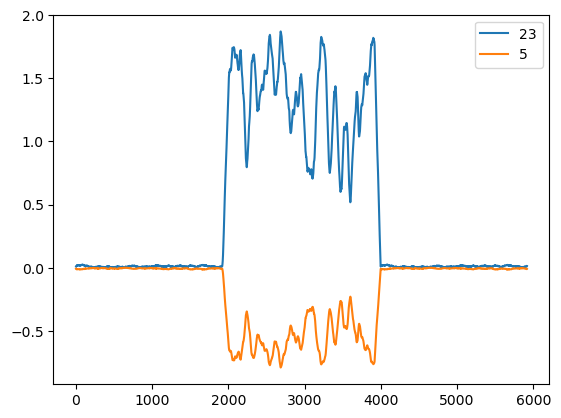

In [15]:
sorted_data_l23_ma_ = ma_2d(sorted_data_l23, window=80)
sorted_data_l5_ma_ = ma_2d(sorted_data_l5, window=80)
plt.plot(sorted_data_l23_ma_[0, :], label='23')
plt.plot(sorted_data_l5_ma_[-1, :] ,label='5')
plt.legend()


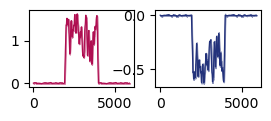

In [16]:
# sampled single neurons at different timestams
l23_neuron = []
l5_neuron = []

for i in range(5):
    l23_neuron.append(sorted_data_l23_ma_[1, i*2:][:sorted_data_l23_ma_.shape[1]-10])
    l5_neuron.append(sorted_data_l5_ma_[-2, i*2:][:sorted_data_l5_ma_.shape[1]-10])
l23_neuron = np.array(l23_neuron)
l5_neuron = np.array(l5_neuron)
l23_neuron.shape, l5_neuron.shape

l23_neuron_mu = np.mean(l23_neuron, axis=0)
l23_neuron_std = np.std(l23_neuron, axis=0)

l5_neuron_mu = np.mean(l5_neuron, axis=0)
l5_neuron_std = np.std(l5_neuron, axis=0)*2

x = np.arange(0, l23_neuron_mu.shape[0], 1)

fig, ax = plt.subplots(1,2, figsize=(3,1))
ax[0].plot(x, l23_neuron_mu, '#af0e51', lw=0.9)
ax[0].fill_between(x, l23_neuron_mu-l23_neuron_std, l23_neuron_mu+l23_neuron_std, edgecolor='#af0e51', facecolor='#af0e51', alpha=0.5)
ax[1].plot(x, l5_neuron_mu, '#23327b', lw=0.9) # af0e51
ax[1].fill_between(x, l5_neuron_mu-l5_neuron_std, l5_neuron_mu+l5_neuron_std, edgecolor='#23327b', facecolor='#23327b', alpha=0.5)

not saving fig
not saving fig


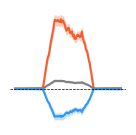

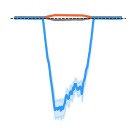

In [17]:
def plot_average_response(data, dmm_idices, null_indices, hmm_indices, name, save_fig):
    fig , ax = plt.subplots(1,1,figsize=(1.5,1.5))
    x = np.arange(0,sorted_data_l23_ma.shape[1])
    y_dmm = data[dmm_idices, :].mean(axis=0)
    y_null = data[null_indices, :].mean(axis=0)
    y_hmm = data[hmm_indices, :].mean(axis=0)

    error_dmm = data[dmm_idices, :].std(axis=0) / 10
    error_null = data[null_indices, :].std(axis=0) / 10
    error_hmm = data[hmm_indices, :].std(axis=0) / 10
    ax.plot(x, y_dmm, '#f55d2f')
    ax.fill_between(x, y_dmm-error_dmm, y_dmm+error_dmm, alpha=0.2, color='#f55d2f')

    ax.plot(x, y_null, 'gray')
    ax.fill_between(x, y_null-error_null, y_null+error_null, alpha=0.2, color='gray')

    ax.plot(x, y_hmm, '#2f98f5')
    ax.fill_between(x, y_hmm-error_hmm, y_hmm+error_hmm, alpha=0.2, color='#2f98f5')
    
    # hline at 0
    ax.axhline(0, color='black', linestyle='--', linewidth=0.5)

    # remove all the ticks (both axes), spines values on the axis
    ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    if save_fig:
        plt.savefig(f'saved_figs/{name}', dpi=300, bbox_inches='tight')
    else:
        print('not saving fig')
        
    
plot_average_response(sorted_data_l23_ma, dmm_idices=np.arange(0,20), null_indices=np.arange(20,25), hmm_indices=np.arange(25,30), name='mm_avg_l23_modulate_l5.svg', save_fig=False)
plot_average_response(sorted_data_l5_ma, dmm_idices=np.arange(0,5), null_indices=np.arange(5,10), hmm_indices=np.arange(10,16), name='mm_avg_l5_modulate_l5.svg', save_fig=False)


/tmp/ipykernel_8263/3927199572.py:29: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


l_pearson=PearsonRResult(statistic=0.9966023805461565, pvalue=1.1740537240090176e-216)
l_pearson=PearsonRResult(statistic=-0.9919518338849931, pvalue=1.1197829390693538e-179)


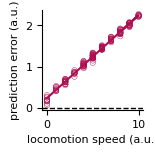

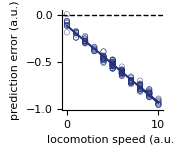

In [18]:
def plot_mm_corr(mm_toy, layer,neuron_idx, name, save_fig=False):
    fig, ax = plt.subplots(1,1, figsize=(1.3,1.3))
    mm = (np.array(mm_toy['mm'][layer]) - np.array(mm_toy['baseline'][layer])).T
    mm = mm[np.mean(mm, axis=1).argsort()][::-1]
    speeds =np.array(mm_toy['mm']['speed']).squeeze()
    mm =mm[:, ::10]
    speeds = speeds[::10]
    c = "#23327b" if layer == 'L5_fc1' else "#af0e51"
    for j in range(mm.shape[1]):

        ax.scatter(speeds[j], mm[neuron_idx, j], s=15, color=c, facecolors='none', linewidths=0.3)

    m, b = np.polyfit(speeds, mm[neuron_idx], 1)
    ax.plot(speeds, m*speeds + b, c=c)

    ax.set_xlabel('locomotion speed (a.u.)', fontsize=config.axis_fontsize)
    ax.set_ylabel('prediction error (a.u.)', fontsize=config.axis_fontsize)
    plt.xticks(fontsize=config.axis_fontsize)
    plt.yticks(fontsize=config.axis_fontsize)
    
    # ax.set_title(layer)
    # draw a line at 0
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    
    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    from scipy.stats.stats import pearsonr  
    l_pearson = pearsonr(speeds, mm[neuron_idx])
    print(f"{l_pearson=}")

    if save_fig is not None:
        plt.savefig(f'saved_figs/{name}', dpi=300, bbox_inches='tight')
    else:
        print('not saving fig')

# plot_mm_corr(mm_toy, save_path='figs/mismatch/toy_scale_mm_corr_8.png')
plot_mm_corr(mm_toy, layer='L2/3_fc1', neuron_idx=0, name="mm_l23_corr_speed.svg" , save_fig=True)
plot_mm_corr(mm_toy, layer='L5_fc1', neuron_idx=-1, name="mm_l5_corr_speed.svg" , save_fig=True)


## Optogenetic Manipulation

In [19]:
def plot_opto(mm_data, dmm_indices, hmm_indices, scale,  layer, name, save_fig=False):
    fig, ax = plt.subplots(1,2, figsize=(3,1.))
    l23_opto_data_ma = ma_2d(np.array(mm_data[scale][layer]), window=50)
    y_dmm_opto = np.array(l23_opto_data_ma[dmm_indices,:]).T.mean(axis=1)
    y_hmm_opto = np.array(l23_opto_data_ma[hmm_indices,:]).T.mean(axis=1)
    y_dmm_error_opto = np.array(l23_opto_data_ma)[dmm_indices,:].T.std(axis=1)
    y_hmm_error_opto = np.array(l23_opto_data_ma)[hmm_indices,:].T.std(axis=1)

    y_dmm_opto.shape, y_hmm_opto.shape, y_dmm_error_opto.shape, y_hmm_error_opto.shape

    ax[0].plot(np.arange(0, y_dmm_opto.shape[0]), y_dmm_opto, '#f55d2f')
    ax[0].fill_between(np.arange(0, y_dmm_opto.shape[0]), y_dmm_opto-y_dmm_error_opto, y_dmm_opto+y_dmm_error_opto, alpha=0.2, color='#f55d2f')

    ax[1].plot(np.arange(0, y_dmm_opto.shape[0]), y_hmm_opto, '#2f98f5')
    ax[1].fill_between(np.arange(0, y_dmm_opto.shape[0]), y_hmm_opto-y_hmm_error_opto, y_hmm_opto+y_hmm_error_opto, alpha=0.2, color='#2f98f5')

    # hline at 0
    ax[0].axhline(0, color='black', linestyle='--', linewidth=0.5)
    ax[1].axhline(0, color='black', linestyle='--', linewidth=0.5)

    # remove all the ticks (both axes), spines values on the axis
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    # set fontsize for ticks
    ax[0].tick_params(axis='both', which='major', labelsize=config.axis_fontsize)
    ax[1].tick_params(axis='both', which='major', labelsize=config.axis_fontsize)
    ax[0].set_xlabel('time', fontsize=config.axis_fontsize)
    ax[0].set_ylabel('prediction error', fontsize=config.axis_fontsize)
    # if save_fig:
    #     plt.savefig(f'saved_figs/{name}', dpi=300, bbox_inches='tight')
    # else:
    #     print('not saving fig')


### Stimulate layer 5

In [20]:
l23_indices_sorted = np.mean(mm_l23_plot, axis=1).argsort()[::-1]
l5_indices_sorted = np.mean(mm_l5_plot, axis=1).argsort()[::-1]

l23_dmm_indices = list(l23_indices_sorted[:10])
l23_hmm_indices = list(l23_indices_sorted[-5:])

l5_dmm_indices = list(l5_indices_sorted[:3])
l5_hmm_indices = list(l5_indices_sorted[-10:])


In [21]:
l5_dmm_indices

[13, 3, 4]

speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])


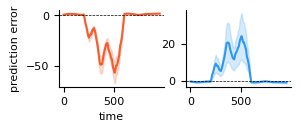

In [31]:
mm_data_l23 = {}
l5_scales = [0, 20, 40, 60, 80]
for l5_scale in l5_scales:

    dataset = SyntheticVisualFlowDataset(num_samples=1000, dimensions=input_dim, max_value=max_value, var_scaler=var_scaler, speed_func="random_walk", num_speeds=num_speeds)
    dataloader_mm = DataLoader(dataset, batch_size=1, shuffle=False)

    mm_toy = get_mm(net, dataloader_mm, recon_loss_coeff=0, l5_scale=l5_scale, l23_scale=0)
    mm_l23_fc1 = (np.array(mm_toy['mm']["L2/3_fc1"]) - np.array(mm_toy['baseline']["L2/3_fc1"])).T
    mm_l5_fc1 = (np.array(mm_toy['mm']["L5_fc1"]) - np.array(mm_toy['baseline']["L5_fc1"])).T
    
    mm_data_l23[l5_scale] = {"L23_fc1":mm_l23_fc1 , "L5_fc1":mm_l5_fc1}
    
dmm_indices = np.mean(mm_data_l23[0]['L23_fc1'], axis=1).argsort()[::-1][:5]
hmm_indices = np.mean(mm_data_l23[0]['L23_fc1'], axis=1).argsort()[::-1][-5:]
plot_opto(mm_data_l23, dmm_indices, hmm_indices, l5_scales[-1], 'L23_fc1', 'l5_opto.svg', save_fig=False)

(32, 999)
(32, 999)
(32, 999)
(32, 999)
(32, 999)
(5, 32)
[ 2 11 13 24] [28]
[array([  1.0063313,  -3.9186153,  -7.761326 , -11.226403 , -12.298056 ],
      dtype=float32), array([-0.7305248,  2.9663172,  5.831011 ,  8.429172 ,  9.237477 ],
      dtype=float32)]
   scale type       mean       std
0      0  dmm   1.006331  0.114567
1     20  dmm  -3.918615  0.563924
2     40  dmm  -7.761326  0.936916
3     60  dmm -11.226403  1.317109
4     80  dmm -12.298056  1.436338
5      0  hmm  -0.730525  0.000000
6     20  hmm   2.966317  0.000000
7     40  hmm   5.831011  0.000000
8     60  hmm   8.429172  0.000000
9     80  hmm   9.237477  0.000000


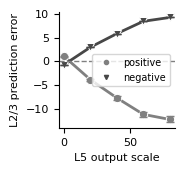

In [34]:
mm_data_mean_l23 = {}
for s in l5_scales:
    print(mm_data_l23[s]['L23_fc1'].shape)
    mm_data_mean_l23[s] = np.mean(mm_data_l23[s]['L23_fc1'], axis=1)
    

mm_data_mean = {"L23_fc1":mm_l23_fc1 , "L5_fc1":mm_l5_fc1}



scale_data = []


for scale in mm_data_l23.keys():
    scale_data.append(mm_data_mean_l23[scale])
scale_data = np.array(scale_data)
print(scale_data.shape)

import seaborn as sns
import pandas as pd
dmm_idx = np.where(np.mean(scale_data[:1, :], axis=0) > 0.8)[0]
hmm_idx = np.where(np.mean(scale_data[:1, :], axis=0) < -0.6)[0]
print(dmm_idx, hmm_idx)
print([np.mean(scale_data[:, dmm_idx], axis=1), np.mean(scale_data[:, hmm_idx], axis=1)])
df = pd.DataFrame(columns=['scale', 'type', 'mean', 'std'])
df['scale'] = l5_scales * 2
df['type'] = ['dmm']*len(l5_scales) + ['hmm']*len(l5_scales)
df['mean'] = np.concatenate([np.mean(scale_data[:, dmm_idx], axis=1), np.mean(scale_data[:, hmm_idx], axis=1)])
df['std'] = np.concatenate([np.std(scale_data[:, dmm_idx], axis=1), np.std(scale_data[:, hmm_idx], axis=1)])



print(df)
fig, ax = plt.subplots(figsize=(1.5, 1.5))
# ensure the color of the line For dMM use the #b51460ff color and for hMM use the #3859a8ff color
sns.lineplot(x="scale", y="mean", hue="type", data=df, ax=ax, linewidth=2, style="type", markers=["o", "v"], markersize=6, dashes=False, palette=["gray", "#474747"], errorbar="se")

ax.set_xlabel("L5 output scale", fontsize=config.axis_fontsize)
# add the error bar 
ax.errorbar(x=l5_scales, y=np.mean(scale_data[:, dmm_idx], axis=1), yerr=np.std(scale_data[:, dmm_idx], axis=1)/ np.sqrt(scale_data.shape[0]) , fmt='none', ecolor='gray', elinewidth=1, capsize=3)
ax.errorbar(x=l5_scales, y=np.mean(scale_data[:, hmm_idx], axis=1), yerr=np.std(scale_data[:, hmm_idx], axis=1)/ np.sqrt(scale_data.shape[0]), fmt='none', ecolor='#474747', elinewidth=1, capsize=3)
ax.set_ylabel("L2/3 prediction error", fontsize=config.axis_fontsize)

ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
# remove legend
ax.legend_.remove()
# set the font size of the ticks
ax.tick_params(axis='both', which='major', labelsize=config.axis_fontsize)
# add the legend
sns.despine()

import matplotlib.lines as mlines
gray_circle = mlines.Line2D([], [], color='gray', marker='o', linestyle='None',
                          markersize=3, label='positive')
black_triangle = mlines.Line2D([], [], color='#474747', marker='v', linestyle='None',
                          markersize=3, label='negative')


marker_legend =plt.legend(handles=[gray_circle, black_triangle], title='', fontsize=config.axis_fontsize-1)
plt.savefig('saved_figs/opto_summary_scales_l23.svg', dpi=300, bbox_inches='tight')

speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])


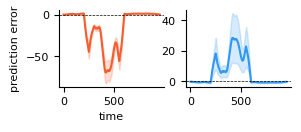

In [25]:
## scale only hmm
mm_data_l23 = {}
l5_scales = [0, 20, 40, 60, 80]
for l5_scale in l5_scales:

    dataset = SyntheticVisualFlowDataset(num_samples=1000, dimensions=input_dim, max_value=max_value, var_scaler=var_scaler, speed_func="random_walk", num_speeds=num_speeds)
    dataloader_mm = DataLoader(dataset, batch_size=1, shuffle=False)

    mm_toy = get_mm(net, dataloader_mm, recon_loss_coeff=0, l5_scale=l5_scale, l23_scale=0, l5_indices=l5_hmm_indices, l23_indices=None)
    mm_l23_fc1 = (np.array(mm_toy['mm']["L2/3_fc1"]) - np.array(mm_toy['baseline']["L2/3_fc1"])).T
    mm_l5_fc1 = (np.array(mm_toy['mm']["L5_fc1"]) - np.array(mm_toy['baseline']["L5_fc1"])).T
    
    mm_data_l23[l5_scale] = {"L23_fc1":mm_l23_fc1 , "L5_fc1":mm_l5_fc1}
    
dmm_indices = np.mean(mm_data_l23[0]['L23_fc1'], axis=1).argsort()[::-1][:5]
hmm_indices = np.mean(mm_data_l23[0]['L23_fc1'], axis=1).argsort()[::-1][-5:]
plot_opto(mm_data_l23, dmm_indices, hmm_indices, l5_scales[-1], 'L23_fc1', 'l5_hmm_opto.svg', save_fig=False)

speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])


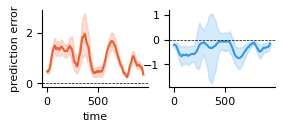

In [26]:
## scale only dmm
mm_data_l23 = {}
l5_scales = [0, 20, 40, 60, 80]
for l5_scale in l5_scales:

    dataset = SyntheticVisualFlowDataset(num_samples=1000, dimensions=input_dim, max_value=max_value, var_scaler=var_scaler, speed_func="random_walk", num_speeds=num_speeds)
    dataloader_mm = DataLoader(dataset, batch_size=1, shuffle=False)

    mm_toy = get_mm(net, dataloader_mm, recon_loss_coeff=0, l5_scale=l5_scale, l23_scale=0, l5_indices=l5_dmm_indices, l23_indices=None)
    mm_l23_fc1 = (np.array(mm_toy['mm']["L2/3_fc1"]) - np.array(mm_toy['baseline']["L2/3_fc1"])).T
    mm_l5_fc1 = (np.array(mm_toy['mm']["L5_fc1"]) - np.array(mm_toy['baseline']["L5_fc1"])).T
    
    mm_data_l23[l5_scale] = {"L23_fc1":mm_l23_fc1 , "L5_fc1":mm_l5_fc1}
    
dmm_indices = np.mean(mm_data_l23[0]['L23_fc1'], axis=1).argsort()[::-1][:5]
hmm_indices = np.mean(mm_data_l23[0]['L23_fc1'], axis=1).argsort()[::-1][-5:]
plot_opto(mm_data_l23, dmm_indices, hmm_indices, l5_scales[-1], 'L23_fc1', 'l5_dmm_opto.svg', save_fig=False)

### simulate L2/3

speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
speeds=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])


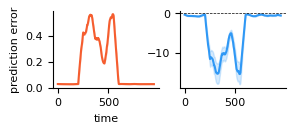

In [27]:
mm_data_l5 = {}
l23_scales = [0, 4, 8, 10, 12]
for l23_scale in l23_scales:

    dataset = SyntheticVisualFlowDataset(num_samples=1000, dimensions=input_dim, max_value=max_value, var_scaler=var_scaler, speed_func="random_walk", num_speeds=num_speeds)
    dataloader_mm = DataLoader(dataset, batch_size=1, shuffle=False)
    sub_group_mask = torch.zeros(1, args.hidden_dim)
    sub_group_mask[:, :] = 1 ## all neurons are optoed
    net.l23.l23_opto_mask = sub_group_mask
    mm_toy = get_mm(net, dataloader_mm, recon_loss_coeff=0, l5_scale=0, l23_scale=l23_scale)
    mm_l23_fc1 = (np.array(mm_toy['mm']["L2/3_fc1"]) - np.array(mm_toy['baseline']["L2/3_fc1"])).T
    mm_l5_fc1 = (np.array(mm_toy['mm']["L5_fc1"]) - np.array(mm_toy['baseline']["L5_fc1"])).T
    
    mm_data_l5[l23_scale] = {"L23_fc1":mm_l23_fc1 , "L5_fc1":mm_l5_fc1}
    
dmm_indices = np.mean(mm_data_l5[0]['L5_fc1'], axis=1).argsort()[::-1][:1]
hmm_indices = np.mean(mm_data_l5[0]['L5_fc1'], axis=1).argsort()[::-1][-2:]
plot_opto(mm_data_l5, dmm_indices, hmm_indices, l23_scales[-4], 'L5_fc1', 'l23_opto.svg', save_fig=False)

(5, 16)
[ 3  8 14] [ 0  1  2  4  6  9 11 15]
[array([0.00154567, 0.45060706, 0.8361036 , 0.59681225, 0.9219987 ],
      dtype=float32), array([-0.13857795, -1.5999212 , -2.7705817 , -2.0167928 , -3.057596  ],
      dtype=float32)]
   scale type      mean       std
0      0  dmm  0.001546  0.002895
1      4  dmm  0.450607  0.125842
2      8  dmm  0.836104  0.236490
3     10  dmm  0.596812  0.168396
4     12  dmm  0.921999  0.260797
5      0  hmm -0.138578  0.174040
6      4  hmm -1.599921  1.743501
7      8  hmm -2.770582  2.997976
8     10  hmm -2.016793  2.186356
9     12  hmm -3.057596  3.309399


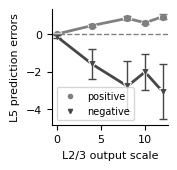

In [35]:
mm_data_mean_l5 = {}
for s in l23_scales:
    mm_data_mean_l5[s] = np.mean(mm_data_l5[s]['L5_fc1'], axis=1)

scale_data = []

for scale in mm_data_l5.keys():
    scale_data.append(mm_data_mean_l5[scale])
scale_data = np.array(scale_data)
print(scale_data.shape)

import seaborn as sns
import pandas as pd
dmm_idx = np.where(np.mean(scale_data[:2, :], axis=0) > 0.1)[0]
hmm_idx = np.where(np.mean(scale_data[:2, :], axis=0) < -0.1)[0]
print(dmm_idx, hmm_idx)
print([np.mean(scale_data[:, dmm_idx], axis=1), np.mean(scale_data[:, hmm_idx], axis=1)])
df = pd.DataFrame(columns=['scale', 'type', 'mean', 'std'])
df['scale'] = l23_scales * 2
df['type'] = ['dmm']*len(l23_scales) + ['hmm']*len(l23_scales)
df['mean'] = np.concatenate([np.mean(scale_data[:, dmm_idx], axis=1), np.mean(scale_data[:, hmm_idx], axis=1)])
df['std'] = np.concatenate([np.std(scale_data[:, dmm_idx], axis=1), np.std(scale_data[:, hmm_idx], axis=1)])



print(df)
fig, ax = plt.subplots(figsize=(1.5, 1.5))
# ensure the color of the line For dMM use the #b51460ff color and for hMM use the #3859a8ff color
sns.lineplot(x="scale", y="mean", hue="type", data=df, ax=ax, linewidth=2, style="type", markers=["o", "v"], markersize=6, dashes=False, palette=["gray", "#474747"], errorbar="se")

ax.set_xlabel("L2/3 output scale", fontsize=config.axis_fontsize)
# add the error bar 
ax.errorbar(x=l23_scales, y=np.mean(scale_data[:, dmm_idx], axis=1), yerr=np.std(scale_data[:, dmm_idx], axis=1)/ np.sqrt(scale_data.shape[0]) , fmt='none', ecolor='gray', elinewidth=1, capsize=3)
ax.errorbar(x=l23_scales, y=np.mean(scale_data[:, hmm_idx], axis=1), yerr=np.std(scale_data[:, hmm_idx], axis=1)/ np.sqrt(scale_data.shape[0]), fmt='none', ecolor='#474747', elinewidth=1, capsize=3)
ax.set_ylabel("L5 prediction errors", fontsize=config.axis_fontsize)

ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
# remove legend
ax.legend_.remove()
sns.despine()
ax.tick_params(axis='both', which='major', labelsize=config.axis_fontsize)

import matplotlib.lines as mlines
# chnage font size of the label i mlines
gray_circle = mlines.Line2D([], [], color='gray', marker='o', linestyle='None',
                          markersize=3, label='positive')

black_triangle = mlines.Line2D([], [], color='#474747', marker='v', linestyle='None',
                          markersize=3, label='negative')

marker_legend =plt.legend(handles=[gray_circle, black_triangle], title='', fontsize=config.axis_fontsize-1)
save_fig=True
if save_fig:
    plt.savefig('saved_figs/opto_summary_scales_l5.svg', dpi=300, bbox_inches='tight')

In [ ]:
# scale only hmm
mm_data_l5 = {}
l23_scales = [0, 4, 8, 10, 12]
for l23_scale in l23_scales:

    dataset = SyntheticVisualFlowDataset(num_samples=1000, dimensions=input_dim, max_value=max_value, var_scaler=var_scaler, speed_func="random_walk", num_speeds=num_speeds)
    dataloader_mm = DataLoader(dataset, batch_size=1, shuffle=False)
    sub_group_mask = torch.zeros(1, args.hidden_dim)
    sub_group_mask[:, l23_hmm_indices] = 1 ## all neurons are optoed
    net.l23.l23_opto_mask = sub_group_mask
    mm_toy = get_mm(net, dataloader_mm, recon_loss_coeff=0, l5_scale=0, l23_scale=l23_scale)
    mm_l23_fc1 = (np.array(mm_toy['mm']["L2/3_fc1"]) - np.array(mm_toy['baseline']["L2/3_fc1"])).T
    mm_l5_fc1 = (np.array(mm_toy['mm']["L5_fc1"]) - np.array(mm_toy['baseline']["L5_fc1"])).T
    
    mm_data_l5[l23_scale] = {"L23_fc1":mm_l23_fc1 , "L5_fc1":mm_l5_fc1}
    
dmm_indices = np.mean(mm_data_l5[0]['L5_fc1'], axis=1).argsort()[::-1][:1]
hmm_indices = np.mean(mm_data_l5[0]['L5_fc1'], axis=1).argsort()[::-1][-2:]
plot_opto(mm_data_l5, dmm_indices, hmm_indices, l23_scales[-4], 'L5_fc1', 'l23_hmm_opto.svg', save_fig=False)

In [ ]:
# only dmm

# scale only hmm
mm_data_l5 = {}
l23_scales = [0, 4, 8, 10, 12]
for l23_scale in l23_scales:

    dataset = SyntheticVisualFlowDataset(num_samples=1000, dimensions=input_dim, max_value=max_value, var_scaler=var_scaler, speed_func="random_walk", num_speeds=num_speeds)
    dataloader_mm = DataLoader(dataset, batch_size=1, shuffle=False)
    sub_group_mask = torch.zeros(1, args.hidden_dim)
    sub_group_mask[:, l23_dmm_indices] = 1 ## all neurons are optoed
    net.l23.l23_opto_mask = sub_group_mask
    mm_toy = get_mm(net, dataloader_mm, recon_loss_coeff=0, l5_scale=0, l23_scale=l23_scale)
    mm_l23_fc1 = (np.array(mm_toy['mm']["L2/3_fc1"]) - np.array(mm_toy['baseline']["L2/3_fc1"])).T
    mm_l5_fc1 = (np.array(mm_toy['mm']["L5_fc1"]) - np.array(mm_toy['baseline']["L5_fc1"])).T
    
    mm_data_l5[l23_scale] = {"L23_fc1":mm_l23_fc1 , "L5_fc1":mm_l5_fc1}
    
dmm_indices = np.mean(mm_data_l5[0]['L5_fc1'], axis=1).argsort()[::-1][:1]
hmm_indices = np.mean(mm_data_l5[0]['L5_fc1'], axis=1).argsort()[::-1][-2:]
plot_opto(mm_data_l5, dmm_indices, hmm_indices, l23_scales[-4], 'L5_fc1', 'l23_dmm_opto.svg', save_fig=False)

## decoding speed

In [ ]:
dataset_ = SyntheticVisualFlowDataset(num_samples=10000, dimensions=input_dim, max_value=max_value, var_scaler=var_scaler, speed_func="random_walk", num_speeds=num_speeds)
dataloader_ = DataLoader(dataset_, batch_size=10000, shuffle=False)
dataloader_test = DataLoader(dataset_, batch_size=10000, shuffle=False)


with torch.no_grad():
    net.to("cpu")
    x1,x2,s1, s2  = next(iter(dataloader_))
    x1 = x1.float()
    x2 = x2.float()
    s1 = s1.float()
    s2 = s2.float()

    x1_ = x1.view(x1.shape[0], -1).clone()
    x2_ = x2.view(x2.shape[0], -1).clone()

    # x1_ = torch.rand_like(x1_)
    l4_out, l23_out, l5_pred, l5_out, recon = net(x1_, x2_, s2)
    
with torch.no_grad():
    net.to("cpu")
    x1,x2,s1, s2  = next(iter(dataloader_test))
    x1 = x1.float()
    x2 = x2.float()
    s1 = s1.float()
    s2 = s2.float()

    x1_ = x1.view(x1.shape[0], -1).clone()
    x2_ = x2.view(x2.shape[0], -1).clone()

    # x1_ = torch.zeros_like(x1_)
    l4_out, l23_out_test, l5_pred, l5_out_test, recon = net(x1_, x2_, s2)

In [ ]:
s2.squeeze()
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(s1.squeeze().numpy())
le.transform(s1.squeeze().numpy())

In [ ]:
l23_out.shape, x1.min(), x1.max(), (s2.squeeze()*10).numpy().astype(int)

In [ ]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16, max_iter=10000)

# fit the model with data
logreg.fit(l23_out.numpy(), le.transform(s1.squeeze().numpy()))

y_pred = logreg.predict(l23_out_test.numpy())
print(np.mean(y_pred == le.transform(s1.squeeze().numpy())))

## exp. data reproduction

In [ ]:
speed_mm=np.array([
[4.9903567984571, 3.5546218487394974],
[3.375120540019253, 6.8823529411764675],
[10.458052073288314, 4.084033613445378],
[13.54146576663453, 1.8151260504201687],
[13.784956605593067, 0.453781512605040],
[18.70781099324975, 1.8907563025210088],
[20.156702025072292, 2.344537815126049],
[23.878977820636436, 2.117647058823529],
[29.04291224686591, 2.117647058823529],
[25.344744455159088, 3.100840336134453],
[23.052073288331684, 3.176470588235293],
[21.632111861137872, 3.630252100840334],
[18.777724204435856, 4.084033613445378],
[17.08534233365475, 4.99159663865546],
[17.092574734811933, 5.218487394957984],
[23.65477338476373, 4.084033613445378],
[29.100771456123397, 3.932773109243697],
[27.950819672131132, 3.857142857142857],
[28.531822565091574, 4.084033613445378],
[29.397299903567955, 4.235294117647058],
[29.081485053037568, 3.327731092436973],
[32.81340405014464, 3.4033613445378172],
[33.1388621022179, 4.61344537815126],
[31.41513982642232, 4.53781512605042],
[32.285438765670165, 4.84033613445378],
[30.274831243972983, 4.764705882352942],
[28.56316297010605, 5.067226890756302],
[26.851494696239115, 5.369747899159664],
[30.595467695274806, 5.823529411764703],
[32.01783992285439, 5.445378151260503],
[34.31774349083892, 5.5966386554621845],
[34.88428158148503, 5.369747899159664],
[33.760848601735745, 6.126050420168065],
[34.341851494696215, 6.352941176470587],
[34.06943105110892, 6.806722689075629],
[34.65043394406939, 7.033613445378149],
[35.513500482160026, 7.109243697478991],
[30.91369334619091, 6.806722689075629],
[30.33269045323044, 6.579831932773107],
[28.042430086788812, 6.731092436974787],
[28.078592092574723, 7.865546218487394],
[30.70395371263257, 9.22689075630252],
[34.397299903567955, 8.092436974789914]])

m, b = np.polyfit(speed_mm[:,0], speed_mm[:,1], 1)

In [ ]:
fig, ax = plt.subplots(figsize=(1.3,1.3))
ax.scatter(speed_mm[:,0], speed_mm[:,1], edgecolors='#af0e51', facecolors='none',s=15, linewidths=0.8 )
plt.plot(speed_mm[:,0], m*speed_mm[:,0] + b, c='#af0e51')

ax.set_xlabel('locomotion speed (cm/s)', fontsize=config.axis_fontsize)
ax.set_ylabel('mismatch responses (mV)', fontsize=config.axis_fontsize)
plt.xticks(fontsize=config.axis_fontsize)
plt.yticks(fontsize=config.axis_fontsize)
ax.axhline(0, color='k', linestyle='--', linewidth=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xticklabels([])
# ax.set_xticks([])
# ax.set_yticklabels([])
# ax.set_yticks([])
plt.savefig('saved_figs/speed_mm_correlation_keller.svg', dpi=300)

In [ ]:
# "#23327b" if layer == 'L5_fc1' else "#af0e51"

In [ ]:
speed_mm=np.array([
[21.406250000000014, -6.801111111111112],
[17.343749999999986, -5.443333333333335],
[17.968750000000014, -2.3455555555555563],
[14.21875, -3.332222222222228],
[12.343750000000014, -2.172222222222217],
[8.4375, -2.6266666666666723],
[11.25, -0.6866666666666745],
[14.53125, 0.5099999999999909],
[10.78125, 1.54999999999999],
[4.0625, 1.928888888888892]])
m, b = np.polyfit(speed_mm[:,0], speed_mm[:,1], 1)
fig, ax = plt.subplots(figsize=(1.3,1.3))
ax.scatter(speed_mm[:,0], speed_mm[:,1], edgecolors='#23327b', facecolors='none',s=15, linewidths=0.8 )
plt.plot(speed_mm[:,0], m*speed_mm[:,0] + b, c='#23327b')

ax.set_xlabel('locomotion speed (cm/s)', fontsize=config.axis_fontsize)
ax.set_ylabel('mismatch responses (mV)', fontsize=config.axis_fontsize)
plt.xticks(fontsize=config.axis_fontsize)
plt.yticks(fontsize=config.axis_fontsize)
ax.axhline(0, color='k', linestyle='--', linewidth=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xticklabels([])
# ax.set_xticks([])
# ax.set_yticklabels([])
ax.set_yticks([0.0, -3, -6])
plt.savefig('saved_figs/speed_mm_correlation_keller_hmm.svg',bbox_inches='tight', dpi=300)